In [1]:
# Import of Python Libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import skimage.morphology as morp
from skimage.filters import rank

In [2]:
# Import of Keras Libs
import tensorflow as tf
import numpy as np
import math
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from keras.layers import GlobalAveragePooling2D,Dense, Activation, Flatten, Input, MaxPooling2D
from keras.layers import Conv2D
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adagrad

Using TensorFlow backend.


In [3]:
from emnist import extract_training_samples
from emnist import extract_test_samples

In [4]:
X_train, y_train = extract_training_samples('letters')
X_test, y_test = extract_test_samples('letters')
X_train = X_train/255.
X_test = X_test/255.
# jedes Pixel in allen Bildern einen Wert zwischen 0 und 1 hat
print(X_train.shape)
print(X_test.shape)
# 124800 Bilder fürs Trainieren
# 20800 Bilder fürs Testen

(124800, 28, 28)
(20800, 28, 28)


Text(0.5, 1.0, 'c')

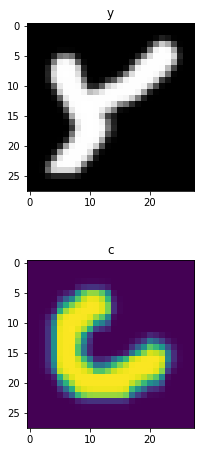

In [5]:
img_index_train = 8888 # das img_index. Image ausnehmen
img_train = X_train[img_index_train]
img_index_test = 1888
img_test = X_test[img_index_test]
plt.figure(figsize=(3,8))
plt.subplot(2, 1, 1)
plt.imshow(img_train.reshape((28,28)), cmap='gray')
plt.title(chr(y_train[img_index_train]+96))
plt.subplot(2, 1, 2)
plt.imshow(img_test.reshape((28,28)))
plt.title(chr(y_test[img_index_test]+96))

In [6]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
# Wiederholte Elemente von Vektor "y_rain" entfern
random.seed(4242)

print("Anzahl der Trainingsbilder ----",n_train)
print("Anzahl der Testbilder ---------",n_test)
print("Bildformat --------------------",image_shape)
print("Anzahl der Klassen ------------",n_classes)

Anzahl der Trainingsbilder ---- 124800
Anzahl der Testbilder --------- 20800
Bildformat -------------------- (28, 28)
Anzahl der Klassen ------------ 26


In [7]:
print("Originale Form X: ", X_train.shape)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 1)
print("Umgeformte X    : ", X_train_reshaped.shape)

Originale Form X:  (124800, 28, 28)
Umgeformte X    :  (124800, 28, 28, 1)


In [8]:
from keras.utils import np_utils
y_test_cat = np_utils.to_categorical(y_test-1, 26)
y_train_cat = np_utils.to_categorical(y_train-1, 26) 

In [9]:
print(y_train[0:40])

[23  7 16 15 23 17 13 11 22 24 10 14 18 21 26 21 21 24 19  5  2 25  9  5
 10 21 11 24 12  1 17  9  1 24 18  1  8  4  1  9]


In [10]:
print("Originale Form X: ", X_train.shape)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test_reshapeed = X_test.reshape(X_test.shape[0], 28, 28, 1)
print("Umgeformte X    : ", X_train_reshaped.shape)

Originale Form X:  (124800, 28, 28)
Umgeformte X    :  (124800, 28, 28, 1)


In [11]:
BATCH_SIZE = 100
EPOCHS = 3
num_class = n_classes

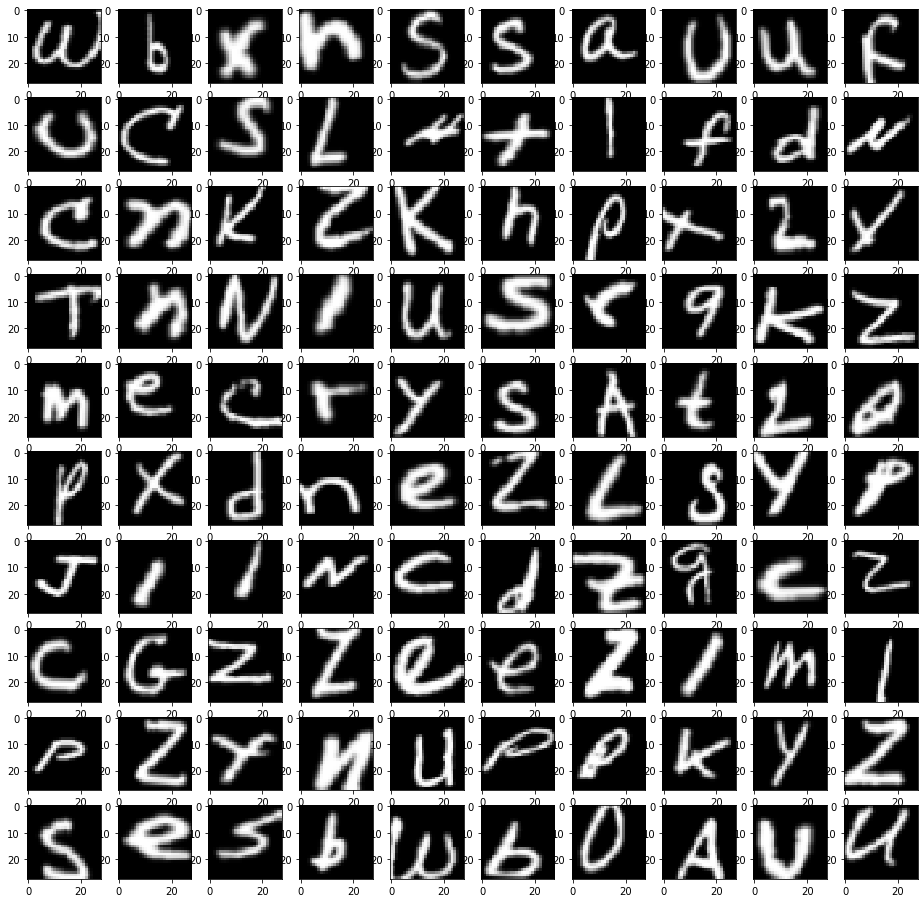

In [12]:
from keras.preprocessing.image import ImageDataGenerator
# Preparing data generators for data augmentation
train_datagen = ImageDataGenerator(shear_range=2, 
                                   zoom_range=0.2, 
                                   rotation_range=5, 
                                   width_shift_range=4, 
                                   height_shift_range=4, 
                                   featurewise_center=False, 
                                   samplewise_center=False, 
                                   featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False)
# fit parameters from data
train_datagen.fit(X_train_reshaped)
# configure batch size and retrieve one batch of images
plt.figure(figsize=(16,16))
for X_batch, y_batch in train_datagen.flow(X_train_reshaped, y_train_cat, batch_size=BATCH_SIZE):
    # create a grid of 10x10 images
    for i in range(0, 100):
        plt.subplot(10,10,i+1)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

train_generator = train_datagen.flow(X_train_reshaped, 
                                     y=y_train_cat, 
                                     batch_size=BATCH_SIZE)

In [13]:
inputs = Input(shape=(28,28,1))

tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(inputs)
tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(inputs)
tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), padding='same', strides=(1, 1))(inputs)
tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(tower_3)

x = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=3)

x = Conv2D(8, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(n_classes)(x)

output = Activation('softmax')(x)

W0625 15:59:59.048233 4743347648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 15:59:59.061110 4743347648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 15:59:59.063765 4743347648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 15:59:59.111975 4743347648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [14]:
# Getting a model-object and displaying the model-structure
model = Model([inputs], output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 64)   128         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0625 15:59:59.176192 4743347648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0625 15:59:59.205329 4743347648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [16]:
# Training the model
#history = model.fit(X_train_gray_reshaped, y_train_cat, validation_data=(X_valid_gray_reshaped, y_valid_cat), batch_size=BATCH_SIZE, epochs=EPOCHS)
model.fit_generator(train_generator,
                    steps_per_epoch=n_train/BATCH_SIZE, #(X_train_gray_reshaped[0] / BATCH_SIZE),
                    epochs=EPOCHS, 
                    verbose=1)

W0625 15:59:59.299090 4743347648 deprecation.py:323] From /Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0625 15:59:59.373093 4743347648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/3
1248/1248 [==============================] - 770s 617ms/step - loss: 1.0291 - acc: 0.6910
Epoch 2/3
1248/1248 [==============================] - 829s 665ms/step - loss: 0.6403 - acc: 0.8051
Epoch 3/3
1248/1248 [==============================] - 1058s 847ms/step - loss: 0.5481 - acc: 0.8316


In [17]:
# Calculating scores on test data
score = model.evaluate(X_test_reshapeed, y_test_cat)

print('Result on Test Set')
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

20800/20800 [==============================] - 42s 2ms/step
Result on Test Set
Test loss:     0.3320590612457062
Test accuracy: 0.8959615384615385


In [18]:
resultingClasses = np.argmax(model.predict(X_test_reshaped), axis=1)
incorrects = np.nonzero(resultingClasses != y_test-1)
print("Total number of misclassifications: ", len(incorrects[0]))

Total number of misclassifications:  2164


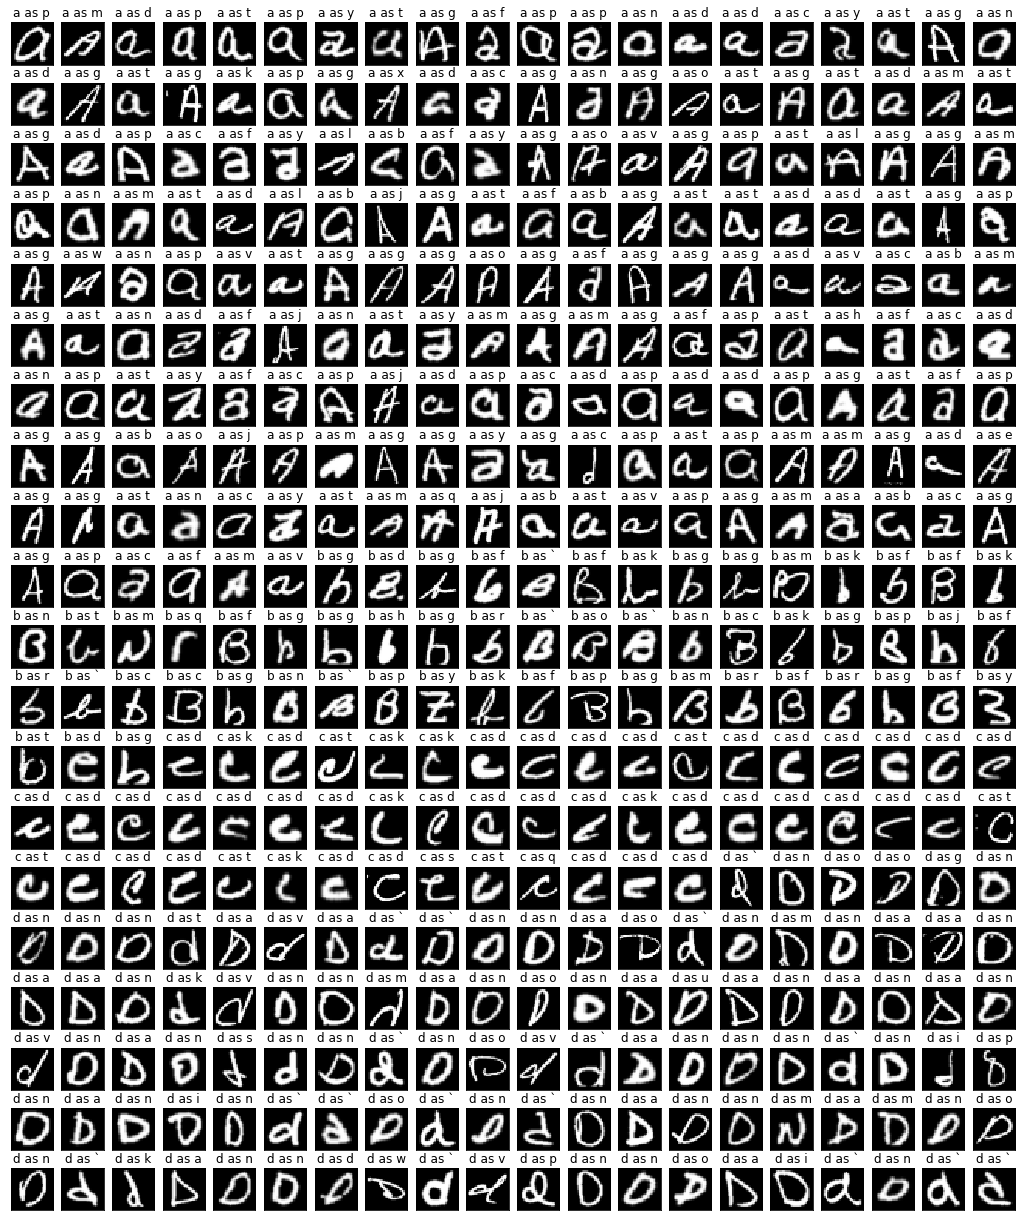

In [19]:
plt.figure(figsize=(18,22))
index = 0
for imageNumber in incorrects[0]:
    #print(imageNumber)
    plt.subplot(20,20,index+1)
    plt.imshow(X_test[imageNumber], cmap='gray')
    plt.title("{} as {}".format(chr(y_test[imageNumber]+96), chr(resultingClasses[imageNumber]+96)))
    plt.xticks([])
    plt.yticks([])
    index = index + 1
    if index >= 400:
        break